In [41]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel
from medclip import MedCLIPProcessor
import pandas as pd
from PIL import Image
import cv2

In [150]:
# Load patient data
rsna_csv = pd.read_csv("../CXR/datasets/train-rsna.csv")
#---- healthy patients ----
healthy = rsna_csv[rsna_csv["Pneumonia_RSNA"] == 0]
healthy_male, healthy_female = healthy[healthy["Sex"] == "M"][:1500], healthy[healthy["Sex"] == "F"][:1500]
#---- pneumonia patients ----
pneumonia = rsna_csv[rsna_csv["Pneumonia_RSNA"] == 1]
pneumonia_male, pneumonia_female = pneumonia[pneumonia["Sex"] == "M"][:1500], pneumonia[pneumonia["Sex"] == "F"][:1500]
#---- filtered RSNA dataset ----
male, female = pd.concat([healthy_male, pneumonia_male]), pd.concat([healthy_female, pneumonia_female])
img_dir = "../CXR/datasets/rsna/"  # Make sure path ends with `/`
len(female)

3000

In [4]:
# load MedCLIP-ResNet50
model = MedCLIPModel(vision_cls=MedCLIPVisionModel)
model.from_pretrained()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


load model weight from: ./pretrained/medclip-resnet


In [110]:
idx = 20
# prepare for the demo image and texts
processor = MedCLIPProcessor()
# image1 = Image.open(img_dir + female["Image Index"].iloc[idx])
# image2 = Image.open(img_dir + female["Image Index"].iloc[idx])
image1 = Image.open(img_dir + female["Image Index"].iloc[idx])
image2 = Image.open(img_dir + female["Image Index"].iloc[idx])
inputs = processor(
    text=["lungs remain severely hyperinflated with upper lobe emphysema", 
        "opacity left costophrenic angle is new since prior exam ___ represent some loculated fluid cavitation unlikely"], 
    images=[image1,image2], 
    return_tensors="pt", 
    padding=True
    )

# pass to MedCLIP model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()
outputs = model(**inputs)
print(outputs.keys())
print(outputs)

/home/runai-home/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used wh

load model weight from: ./pretrained/medclip-vit
dict_keys(['img_embeds', 'text_embeds', 'logits', 'loss_value', 'logits_per_text'])
{'img_embeds': tensor([[-0.0011, -0.0054, -0.0470,  ...,  0.0259, -0.0950, -0.0100],
        [-0.0011, -0.0054, -0.0470,  ...,  0.0259, -0.0950, -0.0100]],
       device='cuda:0', grad_fn=<DivBackward0>), 'text_embeds': tensor([[-0.1691,  0.1067,  0.0112,  ...,  0.0196,  0.0213, -0.0085],
        [-0.1661,  0.1153, -0.0073,  ...,  0.0089,  0.0164,  0.0127]],
       device='cuda:0', grad_fn=<DivBackward0>), 'logits': tensor([[0.1138, 0.6028],
        [0.1138, 0.6028]], device='cuda:0', grad_fn=<TBackward0>), 'loss_value': None, 'logits_per_text': tensor([[0.1138, 0.1138],
        [0.6028, 0.6028]], device='cuda:0', grad_fn=<TBackward0>)}


In [17]:
outputs['img_embeds'].shape

torch.Size([2, 512])

# Embed Male and Female CXRs

In [139]:
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import os

#----- Custom Dataset -----
class RSNADataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["path"]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path)
        return img

In [151]:
# Load patient data
rsna_csv = pd.read_csv("../CXR/datasets/train-rsna.csv")
#---- healthy patients ----
healthy = rsna_csv[rsna_csv["Pneumonia_RSNA"] == 0]
healthy_male, healthy_female = healthy[healthy["Sex"] == "M"][:1500], healthy[healthy["Sex"] == "F"][:1500]
#---- pneumonia patients ----
pneumonia = rsna_csv[rsna_csv["Pneumonia_RSNA"] == 1]
pneumonia_male, pneumonia_female = pneumonia[pneumonia["Sex"] == "M"][:1500], pneumonia[pneumonia["Sex"] == "F"][:1500]
#---- filtered RSNA dataset ----
male, female = pd.concat([healthy_male, pneumonia_male]), pd.concat([healthy_female, pneumonia_female])
img_dir = "../CXR/datasets/rsna/"  # Make sure path ends with `/`

# ----- Dataloader -----
male_dataset = RSNADataset(male, img_dir)
female_dataset = RSNADataset(female, img_dir)

male_loader = DataLoader(male_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, collate_fn=lambda x: x)
female_loader = DataLoader(female_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, collate_fn=lambda x: x)

In [152]:
#----- Get Embeddings -----
def preprocess_inputs(processor, batch):
    return processor(text=["Chest X-ray Images"],
                      images=batch,
                      return_tensors="pt",
                      padding=True)
    
def get_embeddings(model, dataloader):
    all_embeddings = []
    processor = MedCLIPProcessor()
    model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
    model.from_pretrained()
    model.cuda()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = preprocess_inputs(processor, batch)
            all_embeddings.append(model(**inputs)['img_embeds'].cpu())
    return torch.cat(all_embeddings)

male_embeddings = get_embeddings(model, male_loader)
female_embeddings = get_embeddings(model, female_loader)

/home/runai-home/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used wh

load model weight from: ./pretrained/medclip-vit


100%|██████████| 94/94 [01:25<00:00,  1.10it/s]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.pr

load model weight from: ./pretrained/medclip-vit


100%|██████████| 94/94 [01:25<00:00,  1.11it/s]


In [153]:
female_embeddings.shape

torch.Size([3000, 512])

# Train Linear SVM

#### Male Pneumonia Classification performance

In [163]:
import torch
import random
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# prepare dataset
styles, labels = [], []
styles.extend(male_embeddings); labels.extend(list(male["Pneumonia_RSNA"]))
# styles.extend(female_embeddings); labels.extend(list(female["Pneumonia_RSNA"]))

# Convert to NumPy arrays for sklearn compatibility
styles = np.array([style.numpy().flatten() for style in styles])
# styles = torch.stack(styles) 
labels = np.array(labels)
labels

# Shuffle dataset with the same seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Shuffle styles and labels together
indices = np.arange(len(styles))
np.random.shuffle(indices)
styles, labels = styles[indices], labels[indices]

# Split dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(styles, labels, test_size=0.2, random_state=seed)

# Initialize and train linear SVM
# svm_model = SVC(kernel="linear", C=1.0, random_state=seed, tol=1e-5)
# svm_model.fit(X_train, y_train)
clf = make_pipeline(LinearSVC( random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate model
print("Gender Classification Performance:\n", classification_report(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Gender Classification Performance:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       328
           1       0.73      0.81      0.77       272

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600

Accuracy: 77.83%


#### Female Pneumonia Classification performance

In [162]:
# prepare dataset
styles, labels = [], []
# styles.extend(male_embeddings); labels.extend(list(male["Pneumonia_RSNA"]))
styles.extend(female_embeddings); labels.extend(list(female["Pneumonia_RSNA"]))

# Convert to NumPy arrays for sklearn compatibility
styles = np.array([style.numpy().flatten() for style in styles])
# styles = torch.stack(styles) 
labels = np.array(labels)
labels

# Shuffle dataset with the same seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Shuffle styles and labels together
indices = np.arange(len(styles))
np.random.shuffle(indices)
styles, labels = styles[indices], labels[indices]

# Split dataset into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(styles, labels, test_size=0.2, random_state=seed)

# Initialize and train linear SVM
# svm_model = SVC(kernel="linear", C=1.0, random_state=seed, tol=1e-5)
# svm_model.fit(X_train, y_train)
clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate model
print("Gender Classification Performance:\n", classification_report(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Gender Classification Performance:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       328
           1       0.79      0.86      0.83       272

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

Accuracy: 83.67%


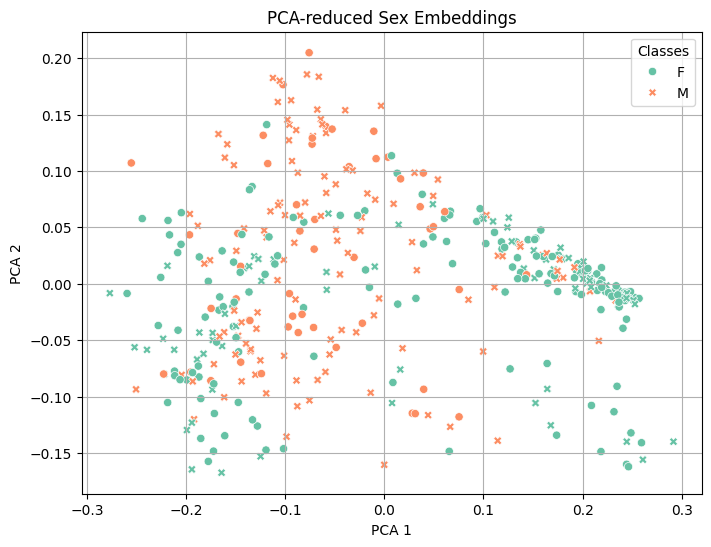

In [107]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Combine test embeddings and predictions
X_vis = X_test
y_vis = y_test
y_pred_vis = y_pred

# Project to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_vis)

# Plot predicted labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred_vis, style=y_vis, palette="Set2")
plt.title("PCA-reduced Sex Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Classes')
plt.grid(True)
plt.show()

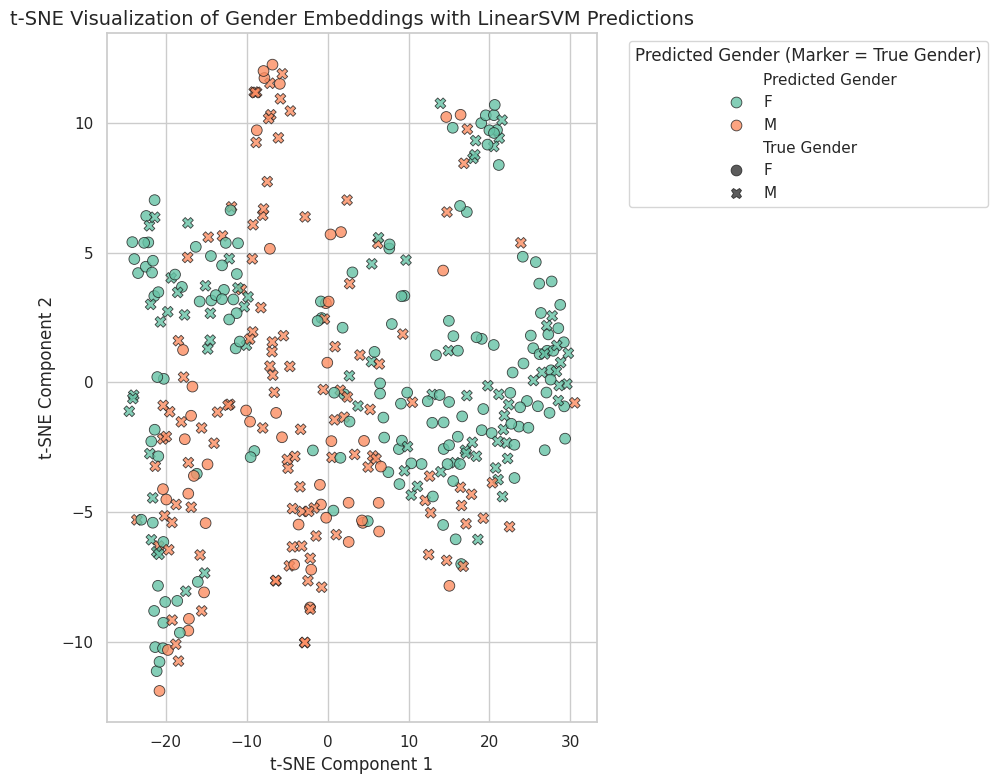

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Reduce embeddings to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_test)

# Create a DataFrame for plotting
import pandas as pd
df_vis = pd.DataFrame({
    'Dim1': X_tsne[:, 0],
    'Dim2': X_tsne[:, 1],
    'True Gender': y_test,
    'Predicted Gender': y_pred
})

# Set figure style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# t-SNE scatter plot colored by predicted gender, styled by true gender
sns.scatterplot(
    data=df_vis,
    x='Dim1', y='Dim2',
    hue='Predicted Gender',
    style='True Gender',
    palette='Set2',
    alpha=0.8,
    s=60,
    edgecolor='k'
)

plt.title('t-SNE Visualization of Gender Embeddings with LinearSVM Predictions', fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Predicted Gender (Marker = True Gender)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

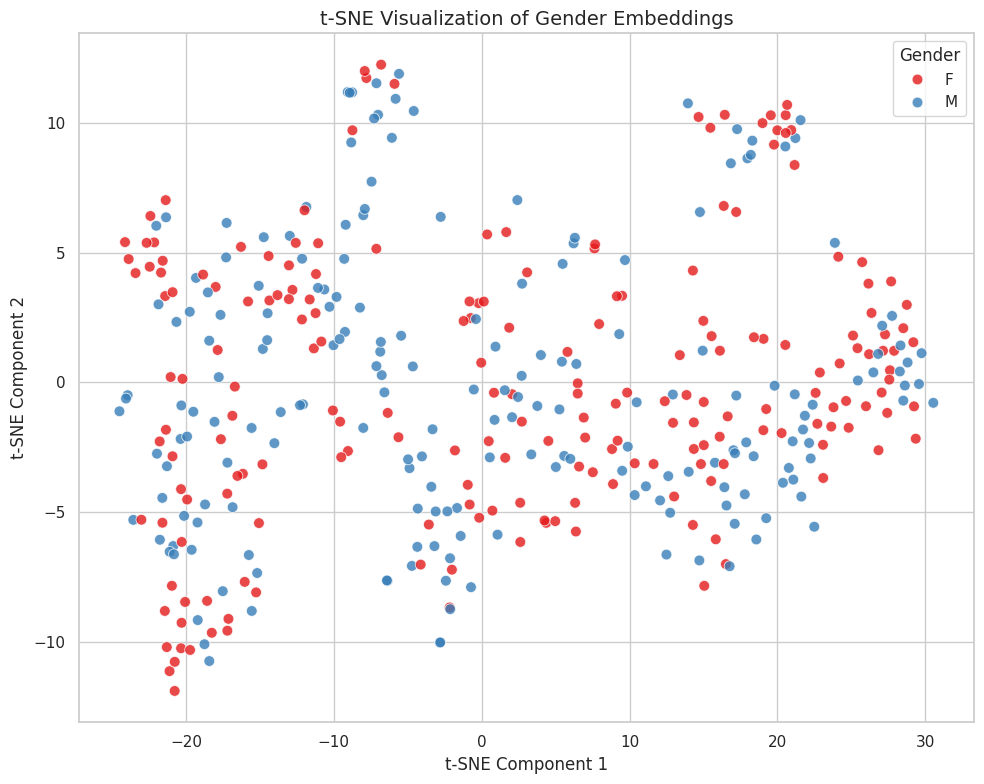

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Run t-SNE on the test embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_test)

# Create DataFrame for plotting
df_vis = pd.DataFrame({
    'Dim1': X_tsne[:, 0],
    'Dim2': X_tsne[:, 1],
    'Gender': y_test
})

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_vis,
    x='Dim1', y='Dim2',
    hue='Gender',
    palette='Set1',  # Or 'Set2', 'Dark2' for different looks
    s=60,
    alpha=0.8
)
plt.title('t-SNE Visualization of Gender Embeddings', fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Gender', loc='best')
plt.tight_layout()
plt.show()